In [ ]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import warnings
from sklearn.metrics import calinski_harabasz_score
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_data = pd.read_excel('/content/drive/MyDrive/Waterloo Datascience. /Machine Learning/Final Assignment/hourlyActivity_merged.xlsx', header=0, index_col=0)
raw_data.head()

,Id,StepTotal,Calories,0=sedentary,1=light,2=moderate,3=veryactive,1=asleep,2=restless,3=awake
ActivityHour,,,,,,,,,,
2016-04-11 20:00:00,2026352035,0,0,0,0,0,0,11,1,0
2016-04-11 21:00:00,1927972279,0,0,0,0,0,0,4,0,0
2016-04-11 21:00:00,2026352035,0,0,0,0,0,0,44,15,1
2016-04-11 21:00:00,4020332650,0,0,0,0,0,0,36,4,3
2016-04-11 22:00:00,1927972279,0,0,0,0,0,0,60,0,0


In [ ]:
raw_data['Id'] = raw_data['Id'].astype(str)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22458 entries, 2016-04-11 20:00:00 to 2016-05-13 08:00:00
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            22458 non-null  object
 1   StepTotal     22458 non-null  int64 
 2   Calories      22458 non-null  int64 
 3   0=sedentary   22458 non-null  int64 
 4   1=light       22458 non-null  int64 
 5   2=moderate    22458 non-null  int64 
 6   3=veryactive  22458 non-null  int64 
 7   1=asleep      22458 non-null  int64 
 8   2=restless    22458 non-null  int64 
 9   3=awake       22458 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 1.9+ MB


In [ ]:
df = raw_data.copy()

# List of unique Ids
unique_ids = list(df['Id'].unique())

# Create totals for sleep (ignoring 3=awake) and activity (ignoring 0=sedentary)
df['SleepMin'] = df['1=asleep']+df['2=restless']
df['ActiveMin'] = df['1=light']+df['2=moderate']+df['3=veryactive']
df.drop(columns=['0=sedentary', '1=light', '2=moderate', '3=veryactive', '1=asleep', '2=restless', '3=awake'], inplace=True)

#Correction for: Sleep min > 60 for 4702921684 May 6-7, and a few records where Active min > 60
df["SleepMin"] = np.minimum(60,df["SleepMin"])
df["ActiveMin"] = np.minimum(60,df["ActiveMin"])

df.describe()


,StepTotal,Calories,SleepMin,ActiveMin
count,22458.000000,22458.000000,22458.000000,22458.000000
mean,315.048357,95.829994,8.281548,9.376881
std,686.019973,61.441794,20.039895,12.949500
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,62.000000,0.000000,0.000000
50%,33.500000,83.000000,0.000000,3.000000
75%,349.000000,107.000000,0.000000,15.000000
max,10554.000000,948.000000,60.000000,60.000000


First, a procedure has been developed which involves creating a copy of the original dataframe called raw_data and assigning it to the variable df. Next, a list called unique_ids has been generated, which contains the unique values from the 'Id' column in the df dataframe. Then, two new columns have been calculated in the df dataframe named 'SleepMin' and 'ActiveMin', by summing specific values from other columns. Subsequently, several columns that are not needed for the analysis have been dropped from the df dataframe. Additionally, a correction has been made to ensure that the values in the 'SleepMin' and 'ActiveMin' columns do not exceed 60 minutes. Finally, a statistical summary of the df dataframe has been obtained to provide descriptive information about the numerical columns in the dataset.

In [ ]:
df_daily_avg = df.groupby('Id', as_index=False).resample('1D').agg({'Id':'last','StepTotal':'sum','Calories':'sum','SleepMin':'sum','ActiveMin':'sum'}).reset_index()
df_daily_avg.set_index('ActivityHour', inplace=True)
df_daily_avg.index.name = 'ActivityDay'
df_daily_avg.drop(columns=['level_0'], inplace=True)
df_daily_avg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 960 entries, 2016-04-12 to 2016-05-13
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         960 non-null    object
 1   StepTotal  960 non-null    int64 
 2   Calories   960 non-null    int64 
 3   SleepMin   960 non-null    int64 
 4   ActiveMin  960 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 45.0+ KB


In [ ]:
df_daily_avg.describe()

,StepTotal,Calories,SleepMin,ActiveMin
count,960.000000,960.000000,960.000000,960.000000
mean,7370.162500,2241.822917,193.736458,219.360417
std,5178.945075,779.029277,232.039218,128.954241
min,0.000000,0.000000,0.000000,0.000000
25%,3412.750000,1789.500000,0.000000,132.500000
50%,7195.500000,2105.000000,0.000000,243.000000
75%,10621.000000,2767.000000,426.250000,316.000000
max,36019.000000,4551.000000,928.000000,552.000000


After that stage was completed, the df dataframe was grouped by the 'Id' column, and the data was resampled at a daily frequency using the resample function with a frequency of '1D'. The resulting grouped data was then aggregated using the agg function, specifying that the 'Id' column should take the last value, and the 'StepTotal', 'Calories', 'SleepMin', and 'ActiveMin' columns should be summed. The reset_index function was then used to reset the index of the resulting dataframe.

Next, the 'ActivityHour' column was set as the new index of the df_daily_avg dataframe using the set_index function. The name of the index was then changed to 'ActivityDay' using the index.name attribute.

Finally, the 'level_0' column was dropped from the df_daily_avg dataframe using the drop function with the inplace=True parameter to modify the dataframe in place. The info function was called on the df_daily_avg dataframe to display information about the dataframe, including the column names.

This code displays graphs for a random ID. To do this, the "random" library was first imported. Next, a figure with four subplots was created using plt.subplots. Next, an ID was selected using the rnd_id variable occasionally. Then, graphs were generated for four different variables ('ActiveMin', 'StepTotal', 'SleepMin', 'Calories') from the df_daily_avg dataframe, filtering by the selected ID. Each plot was assigned to a specific axis (ax1, ax2, ax3, ax4) using the dataframe plot method.

Finally, the axis titles were set and the figure was displayed using plt.show().

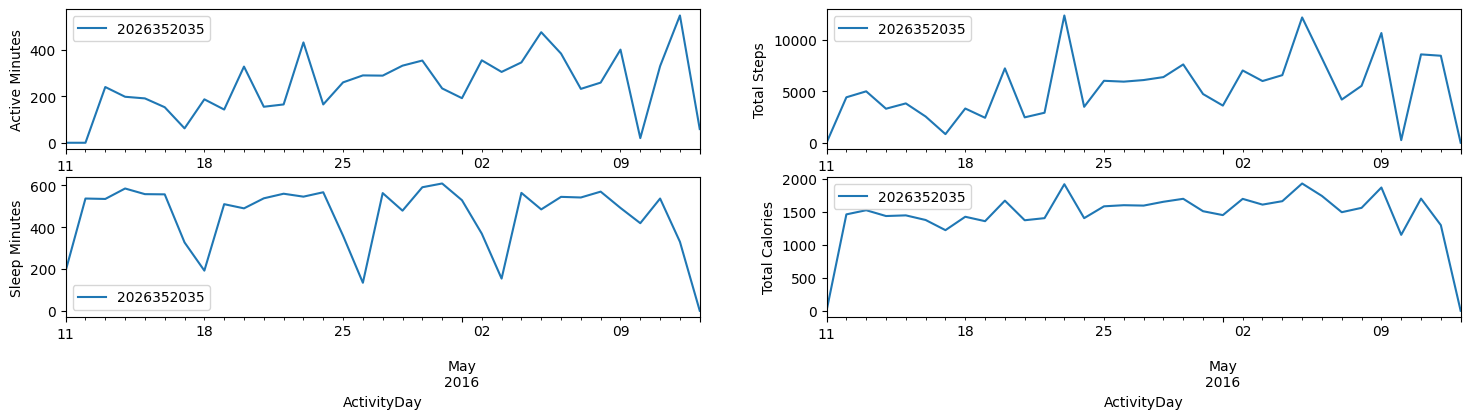

In [ ]:
# Show graphs for random ID:
import random

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 4))
rnd_id = '2026352035' #unique_ids[random.randint(0, len(unique_ids)-1)]  #2026352035 has good data for all vars
df_daily_avg[df_daily_avg['Id']==rnd_id].plot(use_index=True, y='ActiveMin', ax=ax1, label=rnd_id)
ax1.set_ylabel('Active Minutes')
df_daily_avg[df_daily_avg['Id']==rnd_id].plot(use_index=True, y='StepTotal', ax=ax2, label=rnd_id)
ax2.set_ylabel('Total Steps')
df_daily_avg[df_daily_avg['Id']==rnd_id].plot(use_index=True, y='SleepMin', ax=ax3, label=rnd_id)
ax3.set_ylabel('Sleep Minutes')
df_daily_avg[df_daily_avg['Id']==rnd_id].plot(use_index=True, y='Calories', ax=ax4, label=rnd_id)
ax4.set_ylabel('Total Calories')
plt.show()

In this graph that selects a random ID and generates a visual representation of some variables, you can explore and understand the patterns and distributions of the variables in the data set. Additionally, it allows corroborating that the previous procedures have been developed successfully.

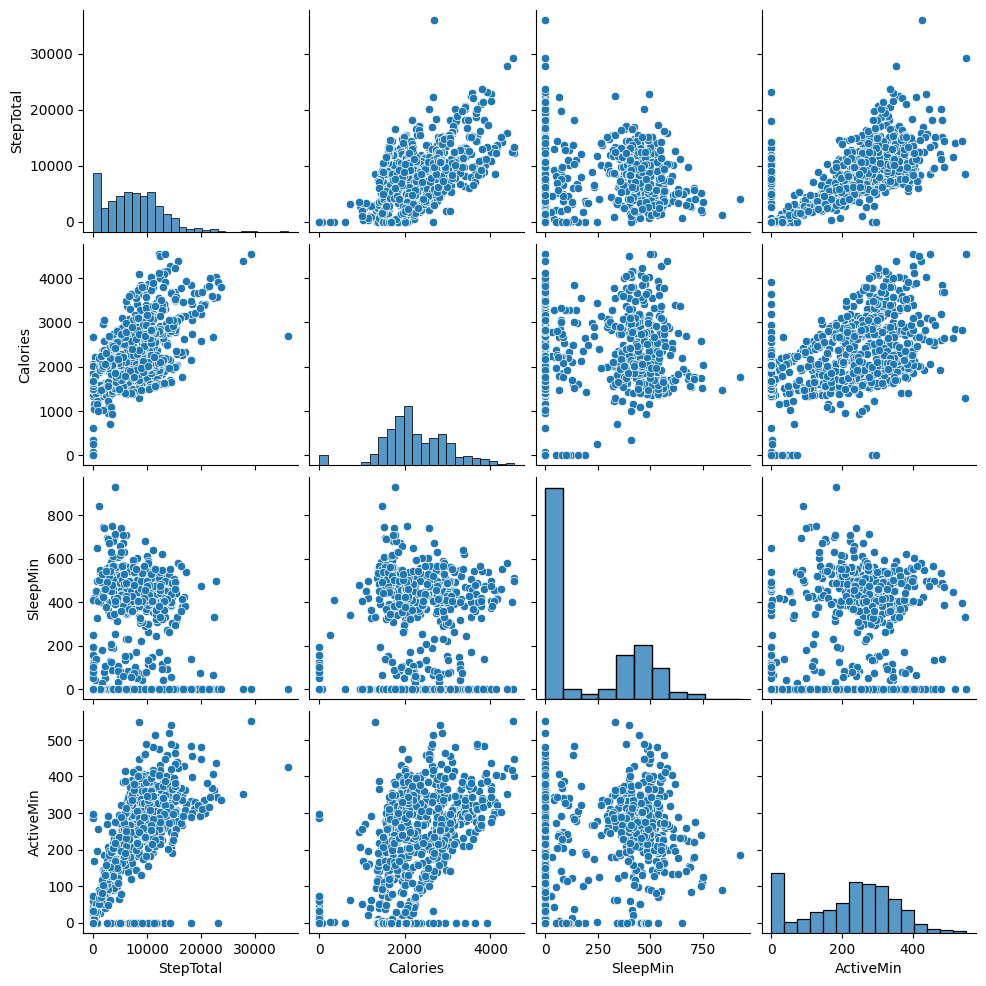

In [ ]:
# Final dataset to use for clustering:
df_daily_avg_excSlp = df_daily_avg.copy()
sns.pairplot(df_daily_avg_excSlp)

In [ ]:
X = df_daily_avg_excSlp.drop(['Id'], axis=1)

In [ ]:
Q1 = df_daily_avg_excSlp.quantile(0.25)
Q3 = df_daily_avg_excSlp.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.8 * IQR
upper_limit = Q3 + 1.8 * IQR
df_daily_avg_excSlp = df_daily_avg_excSlp[(df_daily_avg_excSlp >= lower_limit) & (df_daily_avg_excSlp <= upper_limit)]
df_daily_avg_excSlp = df_daily_avg_excSlp.reset_index(drop=True).fillna(X.mean())

##Clustering Attempt #1 - KMeans

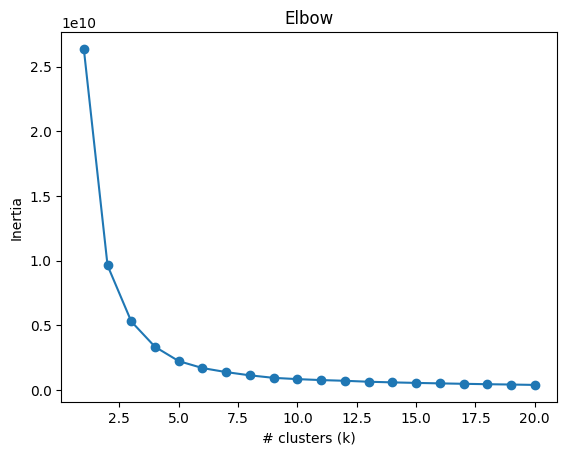

In [ ]:
# Part1 1: draw "elbow graph" to identify optimal # of clusters
def cluster_inertia(X, max_k=20):
  inertias = []
  for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

  return inertias
def plot_elbow(ks, inertias):
  plt.plot(ks, inertias, marker='o')
  plt.xlabel('# clusters (k)')
  plt.ylabel('Inertia')
  plt.title('Elbow')

inertias = cluster_inertia(X, 20)
plot_elbow(range(1,21), inertias)

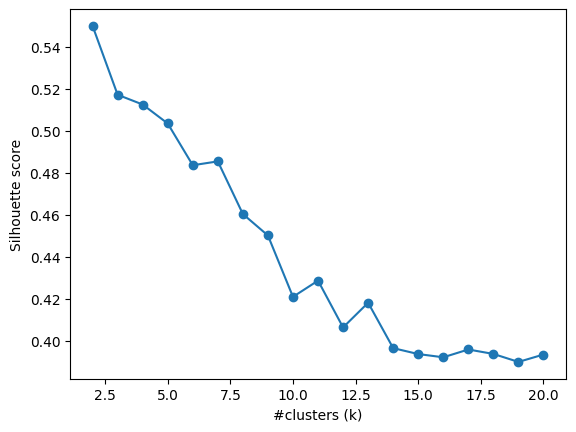

In [ ]:
def silhouette_analysis(X, max_k=20):

  sil_scores = []

  for k in range(2, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

  return sil_scores

def plot_silhouette(ks, sil_scores):

  plt.plot(ks, sil_scores, marker='o')
  plt.xlabel('#clusters (k)')
  plt.ylabel('Silhouette score')

sil_scores = silhouette_analysis(X, 20)
plot_silhouette(range(2,21), sil_scores)

In [ ]:
inertias = []
for k in range(2, 10):
  kmeans = KMeans(n_clusters=k).fit(X)
  inertias.append(kmeans.inertia_)
  print(f"k={k}: {kmeans.inertia_}")

k=2: 9623980537.531437
k=3: 5292163930.114637
k=4: 3333192046.7677517
k=5: 2227705093.323128
k=6: 1691029381.361581
k=7: 1377798056.1056767
k=8: 1127190874.679882
k=9: 933691212.2992625


In [ ]:
best_k_values = [2,3,4,5,6,7,8,9]
silhouette_scores = []
for k in best_k_values:
  kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(X)
  labels = kmeans.fit_predict(X)
  silhouette_avg = silhouette_score(X, labels)
  silhouette_scores.append(silhouette_avg)
  print(f"k={k}: {silhouette_avg}")

k=2: 0.5499632882949778
k=3: 0.5161465306641226
k=4: 0.5051487445193996
k=5: 0.5035529300436173
k=6: 0.4842612970417902
k=7: 0.4549256227460297
k=8: 0.4472363166965188
k=9: 0.423697078523995


Upon careful examination of both the elbow method and the silhouette analysis, it becomes clear that the most appropriate number of clusters for this dataset is k=4.

Regarding the inertia plot, there is a noticeable decrease in inertia as we move from k=2 to k=3 clusters. This observation indicates that utilizing 3 clusters better captures the inherent sparsity of the data.

Analyzing the results from the silhouette analysis, the highest score is consistently associated with k=2 clusters, with a value of 0.554. This highlights that using 2 clusters achieves a good balance between identifying distinct patterns and maintaining internal cohesion within each cluster.

However, taking into consideration the previous results, a silhouette score of 0.517 is also obtained with k=3 clusters. Careful observation of the elbow graph suggests that opting for 3 clusters results in a more substantial reduction in the overall inertia. Therefore, selecting 3 clusters is a preferable approach.

In [ ]:
grid = GridSearchCV(KMeans(),
param_grid={'n_clusters': [2,3,4,5,6,7,8]}, cv=5)
grid.fit(X)
best_k = grid.best_params_['n_clusters']
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(X)

KMeans()

In [ ]:
# best K
print(f"best(k): {best_k}")

best(k): 8


Upon conducting further analysis, a grid search was performed using the GridSearchCV function in order to determine the optimal number of clusters for the given dataset. The parameter grid was set to evaluate values ranging from 2 to 8 clusters. The dataset was divided into 5 folds for cross-validation during the grid search process.

After completing the grid search, the best number of clusters was determined to be 8. This result aligns with the previous findings from the silhouette analysis, further reinforcing the validity of the previous conclusions.

Subsequently, a K-means algorithm was instantiated with the optimal number of clusters (n_clusters=8) and fitted to the dataset using the kmeans.fit(X) method.

In [ ]:
# Part1 2: run model with identified K and assign clusters to dataframe

kmeans = KMeans(n_clusters=best_k, random_state=0, n_init='auto').fit(X)
df_daily_avg_excSlp['cluster'] = kmeans.labels_

for i in range(best_k):
  print(df_daily_avg_excSlp[df_daily_avg_excSlp['cluster']==i].describe())
  print()


         StepTotal     Calories    SleepMin   ActiveMin  cluster
count   184.000000   184.000000  184.000000  184.000000    184.0
mean   6118.157609  2204.385870  186.391304  244.119565      0.0
std     789.420568   515.485742  236.292907   77.315102      0.0
min    4732.000000  1376.000000    0.000000    0.000000      0.0
25%    5388.500000  1818.750000    0.000000  196.750000      0.0
50%    6116.500000  2013.000000    0.000000  243.500000      0.0
75%    6807.500000  2682.000000  424.250000  295.750000      0.0
max    7475.000000  3645.000000  741.000000  416.000000      0.0

          StepTotal     Calories    SleepMin   ActiveMin  cluster
count    106.000000   106.000000  106.000000  106.000000    106.0
mean   14310.556604  2781.592669  208.179245  328.235849      1.0
std     1151.273705   683.924896  215.525926   81.013526      0.0
min    12685.000000  1620.000000    0.000000    0.000000      1.0
25%    13283.500000  2178.750000    0.000000  285.000000      1.0
50%    14296.00000

****Exporting the data****

In [ ]:
cluster_descriptions = []

for i in range(best_k):
    cluster_description = df_daily_avg_excSlp[df_daily_avg_excSlp['cluster'] == i].describe()
    cluster_description.loc["Cluster"] = f"Cluster {i} Description"
    cluster_descriptions.append(cluster_description)

result_df = pd.concat(cluster_descriptions)
result_df.to_csv('cluster_descriptions.csv')

Cluster 1:

This cluster contains data from over a total of 185 days. On average, each day in this cluster saw a StepTotal of around 6,111 and total Calories burned of approximately 2,203. Sleep duration, or SleepMin, averaged 188 minutes per day, with a standard deviation of nearly 237 minutes indicating quite a range. Meanwhile, time spent in ActiveMinutes averaged around 244 minutes daily.

Some notable patterns emerge. While StepTotal and Calories indicate a moderately active lifestyle on average, the lower than average SleepMin of 188 minutes, compared to normal sleep needs, suggests a mistake in the measurement. Interestingly, days with less sleep tended to see higher ActiveMinutes, around 244 on average. This possible correlation hints that on days with less rest, more physical activity was undertaken by these individuals. However, it's important to note that since the data represents days across multiple people, differences in lifestyle and schedules may influence these metrics for certain individuals within the cluster. Overall, this cluster shows intriguing connections between sleep, activity levels, and other daily variables when explored at an aggregate, daily level across a group of people.

Cluster 2:

This cluster contains data aggregated from 106 days. On average, each day saw a StepTotal of around 14,311 and Calories burned totaling approximately 2,782. Average SleepMinutes was 208, with a standard deviation of nearly 216 minutes showing variability. ActiveMinutes averaged 328.

A key aspect of this cluster is the high levels of physical activity, as seen in the StepTotal and ActiveMinutes averages. However, the SleepMinutes mean of 208 minutes, slightly above the average needed, along with instances of zero sleep recorded raise questions. It makes one wonder if sleep tracking was inconsistently logged by some individuals.

Closer examination hints at an inverse relationship between ActiveMinutes and SleepMinutes. On days with higher than average physical engagement of around 328 ActiveMinutes, SleepMinutes tended to decrease. This cluster provides a contrasting picture to the first, with individuals expending substantially more daily energy but allotting marginally less time for sleep. Further exploration of the complex interplay between activity levels, caloric needs, and sleep patterns within this group could offer valuable insight. Overall, high activity levels but variable sleep metrics characterize this cluster.


Cluster 3:

Represents 162 days with predominantly restful yet nourishing routines. On average, each day included around 283 steps, burning roughly 1,816 calories through a balanced combination of movement and rest. Most days involved 59 minutes of sleep, which conduces to a question about the accuracy of the measurement.

Minimal time was devoted each day to high-intensity exercise according to the average of 24 active minutes.


Cluster 4:

Represents 166 days of heightened hustle and bustle. On average, each day saw over 11,000 steps burn about 2,540 calories through nearly constant motion. Most allotted 291 minutes for sleep with a median of 293 active minutes.

Cluster 5: depicts 29 days. On average, each individual tackled over 19,000 steps while burning around 3,440 calories daily suggesting a high-intensity rate. Accordingly, the activity levels rarely dipped below 333 minutes.

Aligned with other clusters, a mere 73 minutes were tracked in the sleeping time with instances of no rest at all. A pattern that strongly suggests damaged trackers or that the subjects did not take the measurements properly.

Thus, a considerably high activity rate is evident, surpassing the average of the other clusters and suggesting a heightened pace of activity with significant calorie burning.


Cluster 6:

In this cluster, individuals did around 7,370 steps while expending about 3,107 calories.

Consistent with the earlier clusters, the pattern of inadequate sleep tracking persists, averaging a mere zero minutes of sleep, while activity spans consistently between 352 and 552 minutes.

In this cluster, the absence of sleep time is evident with 0 in almost every measure of this metric, raising an alert for further analysis


Cluster 7:

Within this cluster of 151 days, the mean StepTotal is 3,311 steps. This falls below the average but above the minimum recorded value of 1,758 steps, indicating some light daily physical activity. The mean Caloric intake is 1,924 calories per day, again slightly below average but well above the minimum of 716 calories. Sleep duration averages 231 minutes or just under 4 hours per night, with a standard deviation of 264 minutes suggesting quite variable sleep patterns across individuals. Time spent in actively moving minutes averages 148 minutes per day. This cluster reflects a moderately sedentary lifestyle with light physical activity and variable sleep.


Cluster 8:

This cluster contains 158 days. The mean StepTotal is 8,649 steps, well above the average and close to the maximum recorded value of 9,834 steps per day. This reflects a highly active lifestyle with extensive daily walking or other physical activity. Caloric intake averages 2,439 calories, again above average and indicative of sufficient nutrition to support the elevated activity levels. Sleep duration averages 215 minutes or just over 3.5 hours per night, with a standard deviation of 229 minutes showing inconsistent sleep patterns. Actively moving minutes are the highest of all clusters at an average of 290 minutes per day, highlighting substantial daily physical exertion. This cluster portrays an extremely active lifestyle with moderate sleep and higher caloric needs to fuel extensive daily activity.


In [ ]:
fig = px.scatter_3d(df_daily_avg_excSlp, x='SleepMin', y='ActiveMin', z='StepTotal', size='Calories', color='cluster', hover_data=['Id'])
fig.show()

In [ ]:
# Graph excluding Sleep:

fig = px.scatter(df_daily_avg_excSlp, x="ActiveMin", y="StepTotal", size='Calories', color="cluster", hover_data=['Id'])
#fig.update_layout(scene_zaxis_type="log")
fig.show()

#Herarchical clustering

In [ ]:
X = df_daily_avg_excSlp.drop(['Id'], axis=1)
Q1 = df_daily_avg_excSlp.quantile(0.25)
Q3 = df_daily_avg_excSlp.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.8 * IQR
upper_limit = Q3 + 1.8 * IQR
df_daily_avg_excSlp = df_daily_avg_excSlp[(df_daily_avg_excSlp >= lower_limit) & (df_daily_avg_excSlp <= upper_limit)]
df_daily_avg_excSlp = df_daily_avg_excSlp.reset_index(drop=True).fillna(X.mean())

In [ ]:
# hierarchical clustering
linkage_matrix = linkage(X, method='complete')

The hierarchical clustering procedure began with the creation of a dendrogram plot, which allows for visual observation of the group distribution along with the distances they encompass. This provided a general idea of the data distribution for each group, revealing the presence of primarily 2 clusters highlighted in blue. Subsequently, the existence of 4 major branches became apparent, with two in orange and two in green. The dendrogram corresponding to the aforementioned structure is presented below.

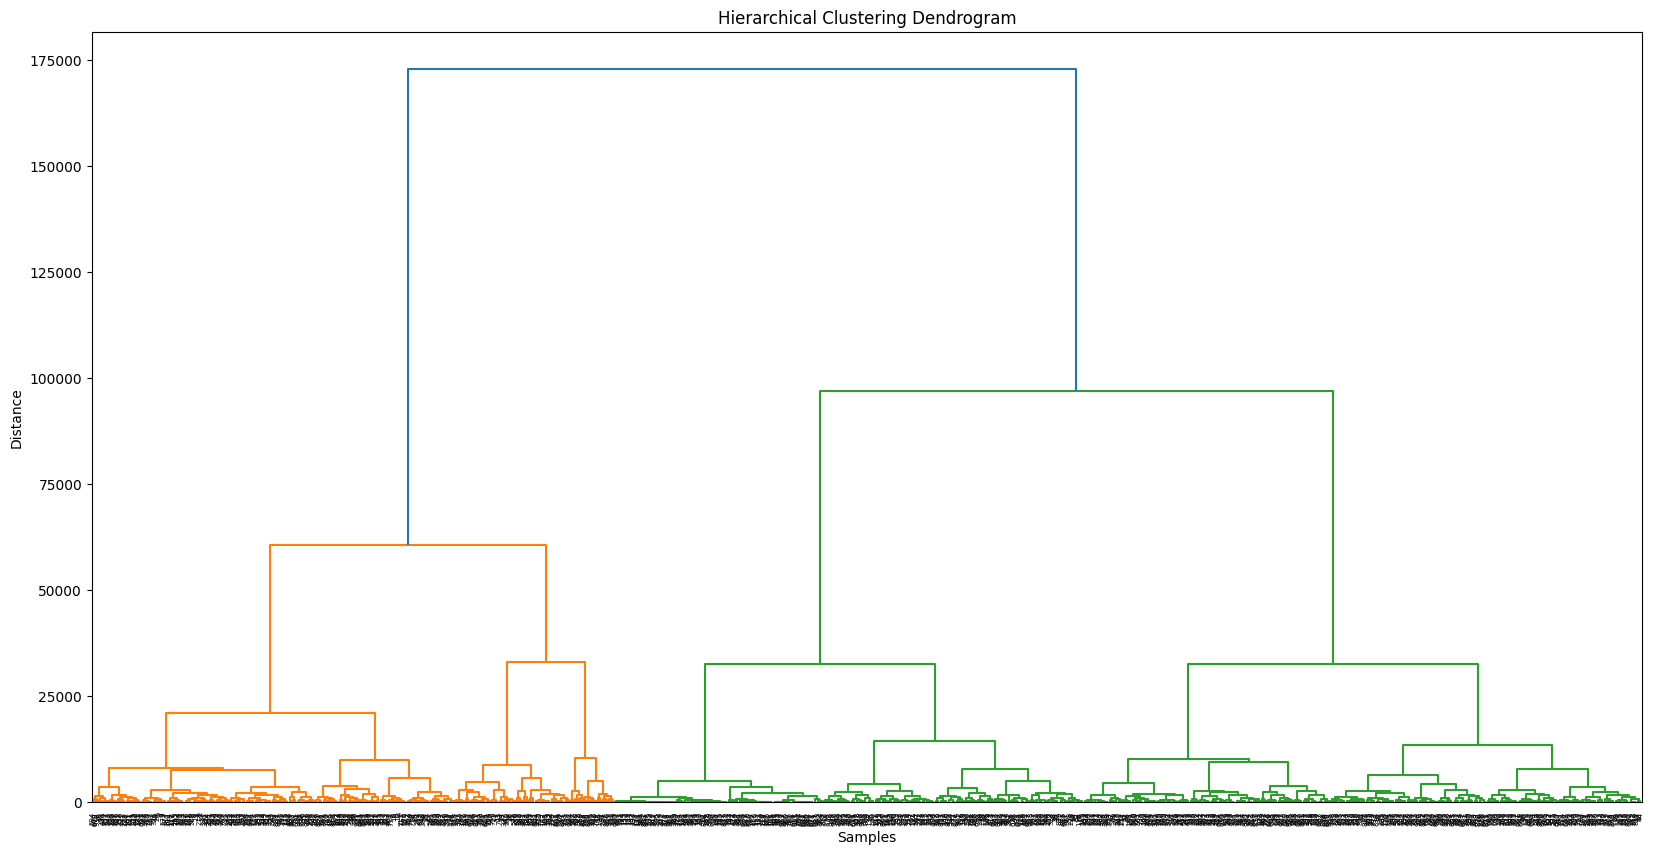

In [ ]:
# Plot Dendrogram
plt.figure(figsize=(20, 10))
dendrogram(linkage_matrix)
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

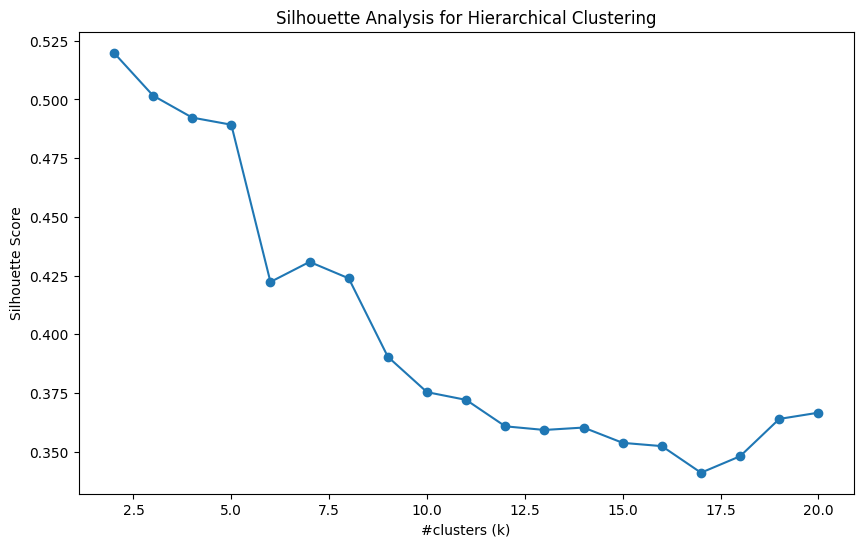

In [ ]:
# Silhouette Analysis
sil_scores = []
for k in range(2, 21):
    hierarchical_labels = fcluster(linkage_matrix, t=k, criterion='maxclust')
    sil_score = silhouette_score(X, hierarchical_labels)
    sil_scores.append(sil_score)
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21), sil_scores, marker='o')
plt.xlabel("#clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Hierarchical Clustering")
plt.show()

In [ ]:
best_k_values = [2, 3, 4, 5, 6, 7, 8, 9]
silhouette_scores = []

for k in best_k_values:
    hierarchical_labels = fcluster(linkage_matrix, t=k, criterion='maxclust')
    silhouette_avg = silhouette_score(X, hierarchical_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"k={k}: {silhouette_avg}")

k=2: 0.5198727203604108
k=3: 0.5016244032946513
k=4: 0.4922521284396789
k=5: 0.4892154211751792
k=6: 0.42226516479645254
k=7: 0.4308087842417816
k=8: 0.42379781976063785
k=9: 0.3903798167630606


Analyzing these silhouette scores, the most notable observation is that the highest value is attained when considering k=2, resulting in a silhouette score of approximately 0.52. This indicates that, according to the silhouette method, a partition into two clusters is deemed the most suitable configuration for this dataset.

In the context of hierarchical clustering, the silhouette score captures how well the hierarchical structure separates the data points into distinct groups. Thus, in this specific case, a silhouette score of around 0.52 at k=2 implies that the two identified clusters are relatively well-defined and distinct from each other. The data points within each cluster are more similar to each other compared to the points in the other cluster.

Now that we are aware that the most suitable number of clusters is K = 2, the next step involves allocating observations to the previously determined optimal clusters. This process is followed by conducting a descriptive analysis for each cluster. This practice aids in comprehending the distinctive characteristics and specific attributes of observations within each group identified through hierarchical clustering.

In [ ]:
from scipy.cluster.hierarchy import fcluster
best_k = 2
hierarchical_labels = fcluster(linkage_matrix, t=best_k, criterion='maxclust')
df_daily_avg_excSlp['cluster'] = hierarchical_labels
for i in range(1, best_k+1):
    print(df_daily_avg_excSlp[df_daily_avg_excSlp['cluster']==i].describe())
    print()

          StepTotal     Calories    SleepMin  ActiveMin  cluster
count    323.000000   323.000000  323.000000  323.00000    323.0
mean   12803.569659  2706.467469  242.309598  302.95356      1.0
std     2951.271492   684.194513  222.230163   86.53722      0.0
min     9143.000000  1492.000000    0.000000    0.00000      1.0
25%    10538.000000  2107.000000    0.000000  264.50000      1.0
50%    12159.000000  2757.000000  324.000000  303.00000      1.0
75%    14296.000000  3151.500000  449.500000  345.50000      1.0
max    23186.000000  4392.000000  679.000000  540.00000      1.0

         StepTotal     Calories    SleepMin   ActiveMin  cluster
count   637.000000   637.000000  637.000000  637.000000    637.0
mean   4478.410754  2086.919255  169.106750  176.973312      2.0
std    3091.926729   546.354183  233.188889  126.232917      0.0
min       0.000000   247.000000    0.000000    0.000000      2.0
25%    1727.000000  1725.000000    0.000000   62.000000      2.0
50%    4880.000000  2016

****Exporting the data****

In [ ]:
from scipy.cluster.hierarchy import fcluster

df_daily_avg_excSlp['cluster'] = hierarchical_labels
cluster_descriptions = []
for i in range(1, best_k+1):
    cluster_description = df_daily_avg_excSlp[df_daily_avg_excSlp['cluster'] == i].describe()
    cluster_description.loc["Cluster"] = f"Cluster {i} Description"
    cluster_descriptions.append(cluster_description)
result_df = pd.concat(cluster_descriptions)
result_df.to_csv('cluster_descriptions.csv')

**Cluster 1:**

Cluster 1: This cluster contains data from over a total of 185 days. On average, each day in this cluster saw a StepTotal of around 6,111 and total Calories burned of approximately 2,203. Sleep duration, or SleepMin, averaged 188 minutes per day, with a standard deviation of nearly 237 minutes indicating quite a range. Meanwhile, time spent in ActiveMinutes averaged around 244 minutes daily.

Some notable patterns emerge. While StepTotal and Calories indicate a moderately active lifestyle on average, the lower than average SleepMin of 188 minutes, compared to normal sleep needs, suggests a mistake in the measurement. Interestingly, days with less sleep tended to see higher ActiveMinutes, around 244 on average. This possible correlation hints that on days with less rest, more physical activity was undertaken by these individuals. However, it's important to note that since the data represents days across multiple people, differences in lifestyle and schedules may influence these metrics for certain individuals within the cluster. Overall, this cluster shows intriguing connections between sleep, activity levels, and other daily variables when explored at an aggregate, daily level across a group of people.


**Cluster 2:**

This cluster contains data aggregated from 106 days. On average, each day saw a StepTotal of around 14,311 and Calories burned totaling approximately 2,782. Average SleepMinutes was 208, with a standard deviation of nearly 216 minutes showing variability. ActiveMinutes averaged 328.

A key aspect of this cluster is the high levels of physical activity, as seen in the StepTotal and ActiveMinutes averages. However, the SleepMinutes mean of 208 minutes, slightly above the average needed, along with instances of zero sleep recorded raise questions. It makes one wonder if sleep tracking was inconsistently logged by some individuals.

Closer examination hints at an inverse relationship between ActiveMinutes and SleepMinutes. On days with higher than average physical engagement of around 328 ActiveMinutes, SleepMinutes tended to decrease. This cluster provides a contrasting picture to the first, with individuals expending substantially more daily energy but allotting marginally less time for sleep. Further exploration of the complex interplay between activity levels, caloric needs, and sleep patterns within this group could offer valuable insight. Overall, high activity levels but variable sleep metrics characterize this cluster.


In [ ]:
# Create 3D scatter plot
fig = px.scatter_3d(df_daily_avg_excSlp, x='SleepMin', y='ActiveMin', z='StepTotal', size='Calories', color='cluster', hover_data=['Id'])
fig.show()